In [66]:
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic_2d
import sys
sys.path.append("../../synthetic_injection_recovery/scripts")
from make_lightcurve import make_lc
from make_params import make
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

df = pd.read_csv("../data/simu1/results.csv")

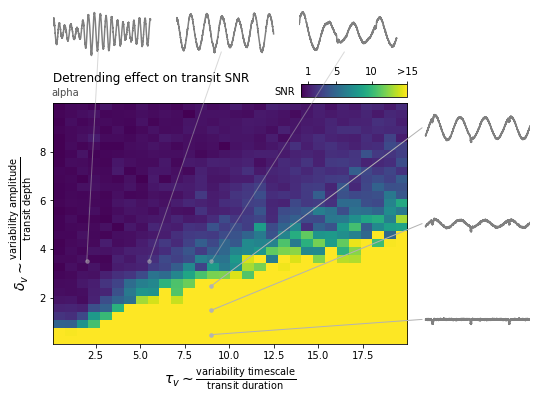

In [206]:
n = 3 # number of small plots
scale = 1.2
W = n+1
H = n+1

fig = plt.figure(None, (1.6*W*scale, H*1.2*scale))

def I(i, j):
    return int(j*W + i) + 1

for i in range(H*W):
    ax = plt.subplot(H, W, i+1)
    
## Main plot
main = plt.subplot(H, W, (I(0, 1), I(W-2, H-1)))

bins=(30, 30)
var, amp, snr = df.values.T.astype(float)
stats = binned_statistic_2d(var, amp, snr, bins=bins)
im = main.imshow(
    stats.statistic.T, 
    origin="lower",
    extent=(
        stats.x_edge.min(), 
        stats.x_edge.max(), 
        stats.y_edge.min(), 
        stats.y_edge.max()
    ),
    aspect="auto",
    vmax=15
)

main.set_ylabel(r"$\delta_v \sim \frac{\mathrm{variability\; amplitude}}{\mathrm{transit\;depth}}$", fontsize=14)
main.set_xlabel(r"$\tau_v \sim \frac{\mathrm{variability\; timescale}}{\mathrm{transit\;duration}}$", fontsize=14)
#main.set_ylabel(r"$\delta_v$", fontsize=12)
#main.set_xlabel(r"$\tau_v$", fontsize=12)
main.set_title("Detrending effect on transit SNR\n", loc="left")
main.text(0, stats.y_edge.max()+0.4, "alpha", color="0.3", va="center")

# removing some axes
# ------------------
ax = plt.subplot(H, W, I(W-1, 0))
plt.axis('off')

# light curves examples
# ---------------------
# zoom box params
a = (0.5, 1) # xy of lower left box
b = (10, 5) # xy of upper right box
pcolor="0.7"
amp = np.linspace(0.5, 3.5, 4)[::-1]
var = np.linspace(2, b[0]-1, 3)
ymax = 0.06
seed = 10

for i, a in enumerate(amp[1::]):
    ax = plt.subplot(H, W, I(W-1, i+1))
    v = b[0] - 1
    params = make(amp=a, var=v, seed=seed)
    x, y, e = make_lc(params, seed)
    ax.plot(x, y, c="0.5")
    ax.set_ylim(-ymax, ymax)
    ax.set_xlim(-0.1, np.max(x))
    plt.axis('off')
    con = ConnectionPatch(
        xyA=(-0.1, 0.), xyB=(v, a), coordsA="data", coordsB="data",
        axesA=ax, axesB=main, color=pcolor)
    fig.add_artist(con)
    main.plot(v, a, ".", c=pcolor, ms=7)

    
for i, v in enumerate(var):
    ax = plt.subplot(H, W, I(i, 0))
    a = amp[0]
    params = make(amp=a, var=v, seed=seed)
    x, y, e = make_lc(params, seed)
    plt.plot(x, y, c="0.5")
    ax.set_ylim(-ymax, ymax)
    ax.set_xlim(0.2, np.max(x)*1.1)
    plt.axis('off')
    con = ConnectionPatch(
        xyA=(np.mean(x), -ymax*0.8), xyB=(v, a), coordsA="data", coordsB="data",
        axesA=ax, axesB=main, color=pcolor, alpha=0.5)
    fig.add_artist(con)
    main.plot(v, a, ".", c=pcolor, ms=7, alpha=0.5)
    
fig.tight_layout(pad=1.5)
axins = inset_axes(
    main,
    width="30%",
    height="5%",
    loc="upper right",
    bbox_to_anchor=(0., 0., 1, 1.08),
    bbox_transform=main.transAxes,
    borderpad=0,
)
cb = fig.colorbar(im, cax=axins, orientation="horizontal", ticks=[1, 5, 10, 15])
cb.set_label("SNR", labelpad=-10, x=-.15)
cb.ax.xaxis.set_ticks_position('top')
_ = cb.ax.set_xticklabels([1, 5, 10, ">15"]) 
plt.savefig("../../../simple/figures/SNRdetrending.pdf")